In [1]:
import cv2
import math
import pathlib
import time
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]
import os
import tensorflow as tf
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow_datasets as tfds
from tensorflow.keras.applications.inception_v3 import preprocess_input


In [2]:
input_folder = "../input/face-recognition-dataset/Extracted Faces/Extracted Faces"

def read_image(index):
    path = os.path.join(input_folder, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

## Split the dataset

In [3]:
def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)
    
    random.shuffle(folders)
    
    train_list, test_list = {}, {}
    
    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files
    
    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files  
    
    return train_list, test_list

train_list, test_list = split_dataset(input_folder, split=0.9)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)

Length of training list: 1191
Length of testing list : 133

Test List: {'1421': 9, '1148': 2, '244': 4, '652': 18, '517': 8, '160': 2, '393': 2, '736': 3, '549': 3, '281': 4, '1326': 9, '165': 15, '1162': 5, '403': 2, '780': 2, '180': 2, '553': 8, '275': 3, '138': 2, '1130': 2, '1595': 2, '361': 3, '1343': 7, '1274': 2, '118': 2, '388': 4, '1368': 4, '1213': 2, '667': 11, '1333': 18, '1418': 2, '1597': 11, '691': 10, '1620': 2, '531': 41, '158': 6, '343': 2, '50': 2, '515': 7, '1043': 6, '436': 2, '1502': 2, '1280': 16, '783': 2, '939': 2, '642': 3, '904': 2, '97': 2, '537': 5, '792': 26, '433': 2, '609': 2, '1612': 5, '788': 6, '772': 8, '900': 10, '1614': 8, '1107': 3, '1167': 2, '542': 2, '1337': 5, '339': 2, '1679': 4, '1666': 14, '167': 8, '6': 16, '1616': 21, '84': 2, '240': 2, '1031': 2, '224': 18, '396': 2, '1146': 3, '450': 5, '1479': 2, '1514': 2, '1218': 2, '555': 13, '1522': 2, '270': 3, '805': 2, '1137': 4, '136': 2, '1245': 2, '991': 4, '1225': 8, '332': 2, '844': 6, '54'

In [4]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

In [5]:
train_triplet = create_triplets(input_folder, train_list)
test_triplet  = create_triplets(input_folder, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 9621
Number of testing triplets : 1610

Examples of triplets:
(('1161', '4.jpg'), ('1161', '5.jpg'), ('1108', '1.jpg'))
(('728', '0.jpg'), ('728', '8.jpg'), ('713', '1.jpg'))
(('1270', '2.jpg'), ('1270', '9.jpg'), ('1424', '0.jpg'))
(('1202', '3.jpg'), ('1202', '4.jpg'), ('1098', '0.jpg'))
(('166', '3.jpg'), ('166', '6.jpg'), ('971', '1.jpg'))


In [6]:
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

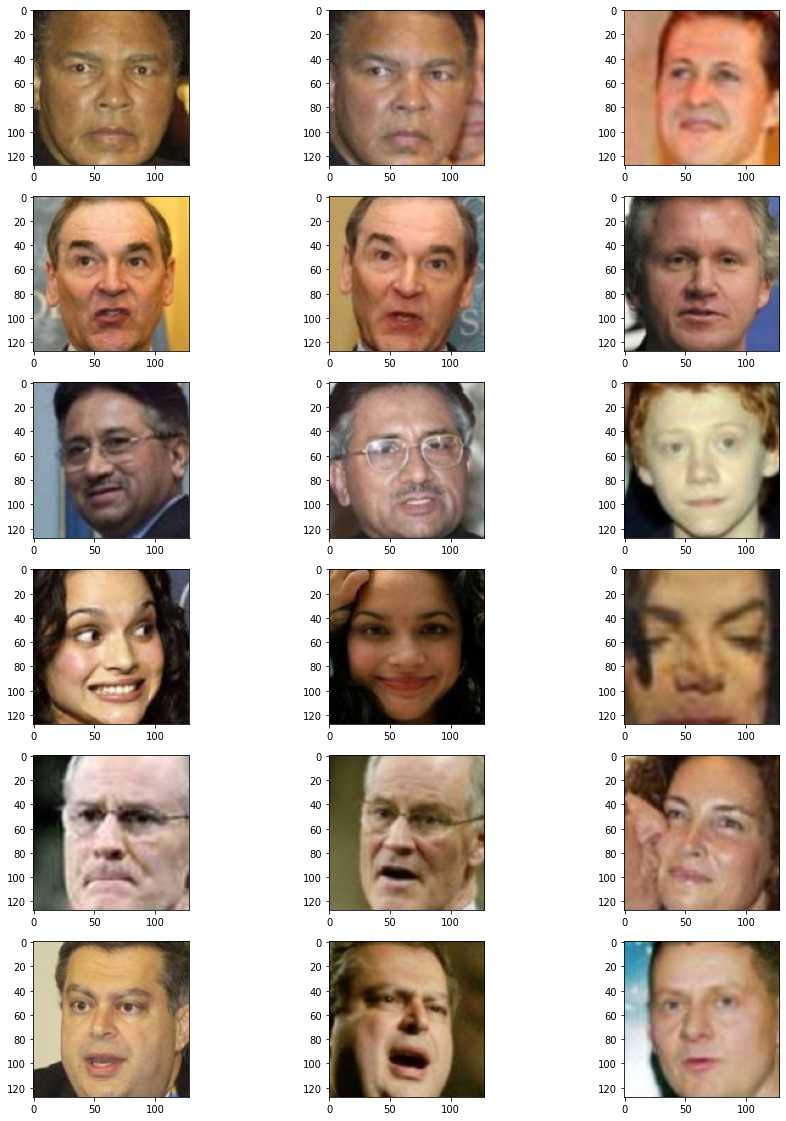

In [7]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

In [10]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.layers import Flatten, Dense ,Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow import keras
from tensorflow.keras import layers

def get_encoder(input_shape):
    """ Returns the image encoding model """

    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape = (128,128,3))#, pooling = 'avg'
    
    base_model.trainable = False

    dimension = 128
    
    Model = Sequential([
        base_model,
        GlobalMaxPooling2D(name='AvgPool'),
        Dropout(1.0-0.8, name='droupout'),
#         BatchNormalization(momentum=0.995, epsilon=0.001, scale=False, name='Bottleneck_BatchNorm'),
#         Flatten(),
#         Dense(dimension, activation ='relu', name='relu_BN' ),
        Dense(dimension, use_bias=False, name='Bottleneck' ),
        BatchNormalization(momentum=0.995, epsilon=0.001, scale=False, name='Bottleneck_BatchNorm'),
#         Dense(dimension, use_bias=False, name='Bottleneck' ),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return Model

In [11]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

2022-06-10 08:29:22.911647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 08:29:23.053471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 08:29:23.054352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 08:29:23.055967: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

219070464/219055592 [==============================] - 2s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor_Input (InputLayer)       [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Positive_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Negative_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Encode_Model (Sequential)       (None, 128)          54533728    Anchor_Input[0][0]               
                 

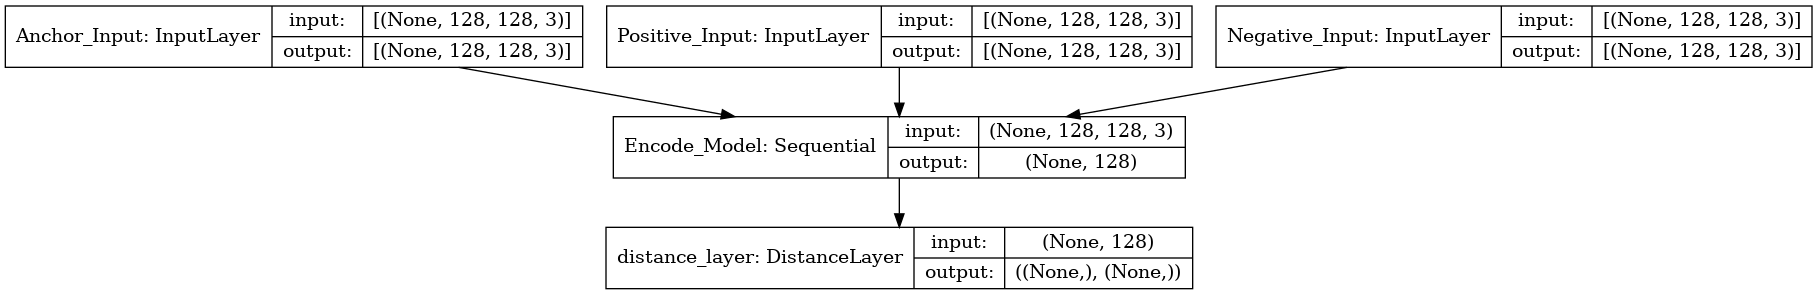

In [12]:
from tensorflow.keras.utils import plot_model

plot_model(siamese_network, show_shapes=True, show_layer_names=True)


In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [14]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam

siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=0.001,epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [15]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [16]:
save_all = False
epochs = 111
batch_size = 256 #128

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
# siamese_model.save_weights("siamese_model-final")

2022-06-10 08:33:23.280902: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-10 08:33:28.854887: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005



EPOCH: 1 	 (Epoch done in 148 sec)
Loss on train    = 0.55314
Accuracy on test = 0.76025

EPOCH: 2 	 (Epoch done in 77 sec)
Loss on train    = 0.45488
Accuracy on test = 0.77950

EPOCH: 3 	 (Epoch done in 72 sec)
Loss on train    = 0.40641
Accuracy on test = 0.78571

EPOCH: 4 	 (Epoch done in 71 sec)
Loss on train    = 0.36689
Accuracy on test = 0.79752

EPOCH: 5 	 (Epoch done in 70 sec)
Loss on train    = 0.33336
Accuracy on test = 0.80870

EPOCH: 6 	 (Epoch done in 72 sec)
Loss on train    = 0.30215
Accuracy on test = 0.80248

EPOCH: 7 	 (Epoch done in 70 sec)
Loss on train    = 0.27487
Accuracy on test = 0.81366

EPOCH: 8 	 (Epoch done in 71 sec)
Loss on train    = 0.25114
Accuracy on test = 0.81739

EPOCH: 9 	 (Epoch done in 71 sec)
Loss on train    = 0.23060
Accuracy on test = 0.81925

EPOCH: 10 	 (Epoch done in 73 sec)
Loss on train    = 0.20746
Accuracy on test = 0.81925

EPOCH: 11 	 (Epoch done in 73 sec)
Loss on train    = 0.19103
Accuracy on test = 0.82981

EPOCH: 12 	 (Epoc